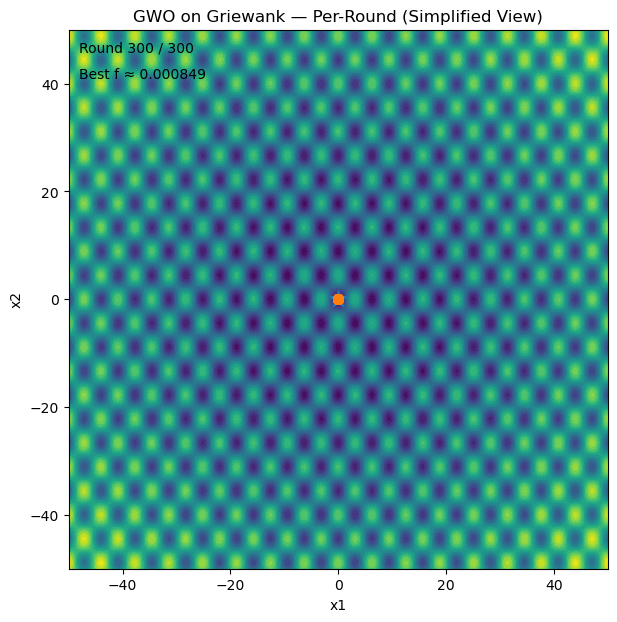

In [ ]:
# GWO on Griewank function (ตามภาพ): inline per-round update, อ่านง่าย
# - Objective: f(x) = 1 + sum(x_i^2/4000) - prod(cos(x_i/sqrt(i)))
# - D = 30, domain = [-600, 600]^D
# - Plot เฉพาะมิติ (x1, x2); ใช้หน้าต่างแสดงผลที่แคบลงเพื่อเห็นลอนได้ชัด (view_window = [-50, 50])
# - no seaborn, single plot, default colors only

import numpy as np
import matplotlib.pyplot as plt
import time
from IPython.display import display, clear_output

# -------------------------------
# กำหนดค่าพื้นฐาน
n_rounds = 300
n_wolves = 20
dim = 30
search_domain = [-600.0, 600.0]   # โดเมนค้นหา
view_window   = [-50.0, 50.0]     # หน้าต่างสำหรับพล็อตให้อ่านง่าย

# ฟังก์ชัน Griewank
def f(pos):
    x = np.asarray(pos, dtype=float)
    i = np.arange(1, x.size + 1, dtype=float)
    return 1.0 + np.sum(x**2 / 4000.0) - np.prod(np.cos(x / np.sqrt(i)))

# สุ่มตำแหน่งหมาป่า
rng = np.random.default_rng()
wolves = [rng.uniform(search_domain[0], search_domain[1], dim) for _ in range(n_wolves)]

# บันทึกตำแหน่งรายรอบ
positions_history = []

for k in range(n_rounds):
    # จัดอันดับ (ค่าน้อยดีกว่า)
    sorted_idx = sorted(range(n_wolves), key=lambda i: f(wolves[i]))
    X_alpha, X_beta, X_delta = wolves[sorted_idx[0]], wolves[sorted_idx[1]], wolves[sorted_idx[2]]

    # เก็บตำแหน่งก่อนอัปเดตในรอบนี้
    positions_history.append(np.array(wolves))

    # อัปเดตหมาป่า (GWO step)
    for i in range(n_wolves):
        X = wolves[i]
        C1, C2, C3 = rng.uniform(0, 2, dim), rng.uniform(0, 2, dim), rng.uniform(0, 2, dim)
        lower, upper = -1 + k / n_rounds, 1 - k / n_rounds
        A1, A2, A3 = rng.uniform(lower, upper, dim), rng.uniform(lower, upper, dim), rng.uniform(lower, upper, dim)
        D_alpha = np.abs(C1 * X_alpha - X)
        D_beta  = np.abs(C2 * X_beta  - X)
        D_delta = np.abs(C3 * X_delta - X)
        X1 = X_alpha - A1 * D_alpha
        X2 = X_beta  - A2 * D_beta
        X3 = X_delta - A3 * D_delta
        X_new = (X1 + X2 + X3) / 3.0
        wolves[i] = np.clip(X_new, search_domain[0], search_domain[1])

# -------------------------------
# เตรียมพื้นผิว Griewank 2D (ใช้มิติ 0 และ 1 ในการวาด)
x = np.linspace(view_window[0], view_window[1], 300)
y = np.linspace(view_window[0], view_window[1], 300)
Xg, Yg = np.meshgrid(x, y)
# สำหรับ 2D: f(x1,x2) = 1 + (x1^2+x2^2)/4000 - cos(x1/√1) * cos(x2/√2)
Z = 1.0 + (Xg**2 + Yg**2) / 4000.0 - np.cos(Xg) * np.cos(Yg / np.sqrt(2.0))

# -------------------------------
# วาดแบบ inline ทีละรอบ
fig, ax = plt.subplots(figsize=(7, 7))
ax.set_xlim(view_window[0], view_window[1])
ax.set_ylim(view_window[0], view_window[1])
ax.set_aspect('equal', 'box')
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_title("GWO on Griewank — Per-Round (Simplified View)")

# เติมสี + เส้นบางเพื่ออ่านง่าย
ax.contourf(Xg, Yg, Z, levels=18)
ax.contour(Xg, Yg, Z, levels=18, linewidths=0.5)

# global minimum (0,0)
ax.scatter([0], [0], marker='*', s=160, zorder=3)

# จุดหมาป่าใหญ่ขึ้น
scat = ax.scatter(positions_history[0][:, 0], positions_history[0][:, 1], s=48, alpha=0.95, zorder=3)

txt_round = ax.text(0.02, 0.98, f"Round 1 / {len(positions_history)}", transform=ax.transAxes,
                    ha="left", va="top")
txt_best  = ax.text(0.02, 0.93, "", transform=ax.transAxes, ha="left", va="top")

def best_value(pos_round):
    return min(f(p) for p in pos_round)

for t, pos in enumerate(positions_history, start=1):
  if t % 10 == 0:
      scat.set_offsets(pos[:, :2])
      txt_round.set_text(f"Round {t} / {len(positions_history)}")
      txt_best.set_text(f"Best f ≈ {best_value(pos):.6f}")
      clear_output(wait=True)
      display(fig)
      plt.pause(0.001)
      time.sleep(0.5)   # ปรับช้าหรือเร็วได้

plt.close(fig)
